# Geopolymer Engineering Optimization Machine Intelligence Novel Designs
Run this file to get the precursor mix proportions formulation from your material target properties.
### Precursors
**Solutions**  
S1 / S3 / SNa / S3'  
**Additives**  
KOH / NaOH  
**Metakaolins**  
M1 / M2 / M3 / M4 / M5
### Properties
**At fresh**  
Initial viscosity (Pa.s) / Mixture density  
**Consolidated**  
Compressive strength (MPa) / Density (g/$cm^3$)
## Packages imports
Required: python 3.9, scipy 1.11, matplotlib 3.8, numpy 1.26, pydash, xgboost 2.0, scikit-learn 1.4, keras 2.15, tensorflow 2.15, tensorflow_probability 0.23 and gpyopt 1.2

In [1]:
import csv as CSV
from pydash import find, map_, filter_, for_each
import numpy as Numpy
from keras import layers as Layers
from keras import Input, Model
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as Backend
from keras.models import load_model
import tensorflow as Tensorflow
import os
import matplotlib.pyplot as Pyplot
from matplotlib.ticker import MaxNLocator
from matplotlib import colormaps, colors, rcParams
from matplotlib.cm import ScalarMappable
from scipy.interpolate import griddata, splev, splrep
from scipy.ndimage import gaussian_filter

#Define font family for figures
rcParams['font.family'] = "DejaVu Serif"
rcParams['font.serif'] = "Times New Roman"

#Load GPU
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

gpus = Tensorflow.config.experimental.list_physical_devices('GPU')
print( "Num GPUs Available : ", len( gpus ) )

try:
  Tensorflow.config.experimental.set_memory_growth(gpus[0], True)
  logical_gpus = Tensorflow.config.experimental.list_logical_devices('GPU')
  print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
  print(e)

2025-08-29 10:35:00.492538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available :  0


IndexError: list index out of range

## Class DataReader declaration

In [2]:
class DataReader:
    def __init__(self, data, separator = ','):
        self.separator = separator
        
        if isinstance( data, str ) and data.endswith( ".csv" ):
            self.setFile( data )
        elif isinstance( data, list ) and find( data, lambda row: not isinstance( row, dict ) ) == None:
            self.data = data
        else:
            raise TypeError( "data must be a csv file or a list of dicts" )
        
    def __readFile(self):
        self.reader = CSV.DictReader( open( self.file, errors = "ignore" ), delimiter = self.separator )
        self.data = map_( self.reader, lambda row: row )
        
    def setFile(self, file):
        self.file = file
        self.__readFile()
        
    def getFile(self):
        return self.file
    
    def getData(self):
        return self.data
    
    def getDataByValue(self, column, value):
        return filter_( self.data, lambda row: row[column] == value )

    def getColumn(self, column):
        return map_( self.data, lambda row: row[column] )
    
    def getColumns(self, columns, as_array = False):
        rows = map_( self.data, lambda row: dict( ( column, row[column]) for column in columns ) )
        if as_array:
            return map_( rows, lambda row: list(row.values())[0:None] )
        else:
            return rows
    
    def getDataAsArray(self, start_x = 0, end_x = None, start_y = 0, end_y = None):
        data_truncated = self.data[start_y:end_y]
        return map_( data_truncated, lambda row: list(row.values())[start_x:end_x] )
        
    def insertColumn(self, column, default_value = 0):
        def add( row ):
            row[column] = default_value
        for_each( self.data, add )
        
    def insertColumns(self, columns, default_values = None):
        if default_values is None: 
            return for_each( columns, lambda column, index: self.insertColumn( column ) )
    
        return for_each( columns, lambda column, index: self.insertColumn( column, default_values[index] ) )
    
    def setValue(self, column, row_id, value):
        self.data[row_id][column] = value

## Relative constants declaration
You can configure these parameters

In [4]:
#Training models constants
NB_PROPERTIES = 6
NB_PRECURSORS = 11
DATA_FILE = "data/geopolymers_23_07.csv"
NB_EPOCHS_SIMULATOR = 250
NB_EPOCHS_FORMULATOR = 300
SHOULD_LOAD_MODELS = False
BATCH_SIZE = 16
LOW_VISCOSITY_MAX = 2
MEDIUM_VISCOSITY_MAX = 100
HIST_N_BINS = 30

#Molar ratios constants
SIO2_S1 = 14.32
SIO2_S3 = 18.68
SIO2_SNA = 27.50
SIO2_S3p = 23.4
SIO2_M1 = 55
SIO2_M2 = 55
SIO2_M3 = 54
SIO2_M4 = 52.4
SIO2_M5 = 59.9
K2O_S1 = 6.41
K2O_S3 = 21.92
K2O_SNA = 8.30
K2O_S3p = 21.7
K2O_KOH = 0.857
K2O_NAOH = 0.97
ALO_M1 = 40
ALO_M2 = 39
ALO_M3 = 46
ALO_M4 = 45.3
ALO_M5 = 35.3

## Figures functions declaration

In [5]:
#This function is used in order to get a spline curve interpolated from an histogram
def getSplineHist(x, nbins = 50):
    count, bin_edges = Numpy.histogram(x, bins = nbins, weights = Numpy.ones(len(x)) / len(x) * 100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    x_bins = Numpy.linspace(min(bin_centers), max(bin_centers), 300)
    spline = splrep(bin_centers, count, k = 3, s=5)
    hist_spline = splev(x_bins, spline)
    hist_spline = Numpy.where(hist_spline > 0, hist_spline, 0)
    
    return hist_spline, x_bins, bin_edges

#This function create, show and save a heatmap interpolated from 3 arrays of points (not a grid)
def heatmap(x, y, z, x_label, y_label, c_label, file_name, nbins = 500, cmap = colormaps["gist_ncar"].reversed(), label = None, xmin = None, xmax = None, ymin = None, ymax = None, zmin = None, zmax = None, x_scale = None, y_scale = None, areas = None, areas_labels = None, should_scatter = True):
    #Scaling values
    if x_scale is not None:
        if x_scale == "log":
            x = Numpy.log10(x)
    if y_scale is not None:
        if y_scale == "log":
            y = Numpy.log10(y)
            
    #Get limits and grid
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    if ymin is None:
        ymin = y.min()
    if ymax is None:
        ymax = y.max()
    if zmin is None:
        zmin = z.min()
    if zmax is None:
        zmax = z.max()
    
    x_offset = (xmax - xmin) * 0.01
    y_offset = (ymax - ymin) * 0.01
    
    xi = Numpy.linspace(xmin-x_offset, xmax+x_offset, nbins)
    yi = Numpy.linspace(ymin-y_offset, ymax+y_offset, nbins)
    xi, yi = Numpy.meshgrid(xi, yi)

    #Fill grid and interpolate values
    zi = griddata((x, y), z, (xi, yi), method='linear', fill_value = zmin, rescale = True)
    zi_smoothed = gaussian_filter(zi, sigma=1.)

    figure = Pyplot.figure(figsize=(8, 6))
    
    #Render areas contours from points
    if areas is not None:
        lines = []
        labels = []
        color_cycle = Pyplot.rcParams['axes.prop_cycle'].by_key()['color']
        line_cycle = [':', '--', '-', '-', '-.', '--', ':', '-.', '-', '--', ':', '-.']
        for i in range(len(areas)):
            area_xi = xi
            area_yi = yi
            area_x, area_y, area_z = areas[i]
            
            if x_scale is not None:
                if x_scale == "log":
                    area_x = Numpy.log10(area_x)
            if y_scale is not None:
                if y_scale == "log":
                    area_y = Numpy.log10(area_y)
            
            area_zi = griddata((area_x, area_y), area_z, (area_xi, area_yi), method='linear', fill_value = zmin, rescale = True)
            
            if x_scale is not None:
                if x_scale == "log":
                    area_xi = 10**area_xi
            if y_scale is not None:
                if y_scale == "log":
                    area_yi = 10**area_yi
                    
            contours = Pyplot.contour(area_xi, area_yi, area_zi, [zmin], colors = color_cycle[i], zorder = 1, linestyles = line_cycle[i])

            line, title = contours.legend_elements()
            lines.append(line[0])
            if areas_labels is None:
                labels.append(title)
            else:
                labels.append(areas_labels[i])
                
        Pyplot.legend(lines, labels, loc="upper left")
    
    #Scaling values
    if x_scale is not None:
        if x_scale == "log":
            xi = 10**xi
            x = 10**x
    if y_scale is not None:
        if y_scale == "log":
            yi = 10**yi
            y = 10**y
    
    #Render heatmap, colorbar, axis and labels
    heatmap = Pyplot.pcolormesh(xi, yi, zi_smoothed, cmap= cmap, shading='auto', zorder = 0, vmin = zmin, vmax = zmax)

    cbar = Pyplot.colorbar(heatmap)
    cbar.set_label(c_label)
    
    Pyplot.xlabel(x_label)
    Pyplot.ylabel(y_label)
    
    if x_scale is not None:
        Pyplot.xscale(x_scale)
    if y_scale is not None:
        Pyplot.yscale(y_scale)
    
    if label is not None:
        Pyplot.annotate(label, xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize', verticalalignment='top')

    #Scatter data points
    if should_scatter:
        Pyplot.scatter(x, y, c=z, cmap=cmap, s=30, edgecolors= "black", vmin = zmin, vmax = zmax, zorder = 2) 
        
    Pyplot.savefig(file_name, dpi = 300 )
    Pyplot.show()
    
    return figure, heatmap

#This function create, show and save an histogram 2D and histograms 1D of each axis
def hist2D(x, y, x_label, y_label, file_name, x_color = 'blue', y_color = 'red', nxbins = 50, nybins = 50, nbins = 100, cmap = colormaps["gist_ncar"].reversed(), x_scale = None, y_scale = None):
    Pyplot.clf()

    #Scaling values
    if x_scale is not None:
        if x_scale == "log":
            x = Numpy.log10(x)
    if y_scale is not None:
        if y_scale == "log":
            y = Numpy.log10(y)

    #Create figure and axis
    fig, ((axHistx,axNull),(axTemperature,axHisty)) = Pyplot.subplots(2,2, figsize=(6,6), gridspec_kw={'width_ratios':[3,1], 'height_ratios': [1,3], "hspace": 0.1, "wspace": 0.1})
    #axTemperature.set_box_aspect(aspect=1)
    axHistx.sharex(axTemperature)
    axHisty.sharey(axTemperature)
    axTemperature.xaxis.set_major_locator(MaxNLocator(5))
    axTemperature.yaxis.set_major_locator(MaxNLocator(5))
    axNull.set_box_aspect(5)
    
    # Find the min/max of the data
    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)
    
    #Fill grid and interpolate values
    H, xedges, yedges = Numpy.histogram2d(x, y, bins=(nxbins, nybins))
    H = gaussian_filter(H, sigma=1.)
    H = H / Numpy.max(H)
    norm_color = colors.Normalize(vmin=Numpy.min(H), vmax=Numpy.max(H))
    
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    xcenters[0] = xedges[0]
    xcenters[-1] = xedges[-1]
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    ycenters[0] = yedges[0]
    ycenters[-1] = yedges[-1]
    
    H = H.flatten()
    valid_mask = Numpy.isfinite(H)
    H = H[valid_mask]
    x_centers_flat = Numpy.repeat(xcenters, len(ycenters))[valid_mask]
    y_centers_flat = Numpy.tile(ycenters, len(xcenters))[valid_mask]

    #Plot the axes labels
    axTemperature.set_xlabel(x_label,fontsize=10)
    axTemperature.set_ylabel(y_label,fontsize=10)
    axHisty.set_xlabel("Distribution (%)",fontsize=10)
    axHistx.set_ylabel("Distribution (%)",fontsize=10)
     
    #Set up the histogram bins
    xbins = Numpy.linspace(xmin, xmax, nbins)
    ybins = Numpy.linspace(ymin, ymax, nbins)
    xi, yi = Numpy.meshgrid(xbins, ybins)
    zi = griddata((x_centers_flat, y_centers_flat), H, (xi, yi), method='linear', fill_value = Numpy.min(H), rescale = True)
    
    #Get histograms spline curves
    histx_spline, spline_x_bins, xbins = getSplineHist(x, nxbins)
    histy_spline, spline_y_bins, ybins = getSplineHist(y, nybins)
    
    #Scaling values
    if x_scale is not None:
        axTemperature.set_xscale(x_scale)
        xbins = 10**xbins
        spline_x_bins = 10**spline_x_bins
        x = 10**x
        xi = 10**xi
    if y_scale is not None:
        axTemperature.set_yscale(y_scale)
        ybins = 10**ybins
        spline_y_bins = 10**spline_y_bins
        y = 10**y
        yi = 10**yi
        
    #Plot the temperature data
    axTemperature.pcolormesh(xi, yi, zi, cmap= cmap, shading='gouraud', norm = norm_color)
    axTemperature.scatter(x, y, color='black', s=1) 
    
    #Plot the histograms
    axHistx.hist(x, bins=xbins, color = x_color, weights = Numpy.ones(len(x)) / len(x) * 100)
    axHisty.hist(y, bins=ybins, orientation='horizontal', color = y_color, weights = Numpy.ones(len(y)) / len(y) * 100)

    axHisty.tick_params(labelleft=False)
    axHistx.tick_params(labelbottom=False)
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(4))
    
    axHistx.plot(spline_x_bins, histx_spline, c = "k", linewidth=1)
    axHisty.plot(histy_spline, spline_y_bins, c = "k", linewidth=1)
    
    fig.colorbar(ScalarMappable( norm = norm_color, cmap = cmap ), cax = axNull )
    
    Pyplot.tight_layout()
    
    # Save to a File
    Pyplot.savefig(file_name, dpi = 300 )
     
    #Show the plot
    Pyplot.show()

## Normalization functions declaration

In [6]:
def getFloats( data ):
    floats = []
    for value in data:
        if value == '':
            continue
        floats.append(value.replace(',', '.'))
        
    return Numpy.array(floats).astype(Numpy.double)

def formatFloats( data, mean, std, should_standardize = True, should_logarithm = False ):
    formatted = []
    for value in data:
        if value == '':
            value = 0
        else:   
            value = float(value.replace(',', '.'))
            if should_logarithm:
                value = value if value > 0 else 1e-6
                value = Numpy.log(value)
            if should_standardize:
                value = ( value - mean ) / std
            
        formatted.append(value)
        
    return Numpy.array(formatted).astype(Numpy.double)

def normalizeData( data, mean = None, std = None, should_standardize = True, should_logarithm = False ):
    floats = getFloats(data)
    
    if should_logarithm:
        floats = Numpy.where( floats > 0, floats, 1e-5 )
        floats = Numpy.log(floats)
    if mean is None:
        mean = floats.mean()
    if std is None:
        std = floats.std()
        
    data = formatFloats(data, mean, std, should_standardize, should_logarithm)

    return data, mean, std

## Molar ratios calculation function declaration

In [7]:
def getMoleRatios( precursors ):
    s1, s3, sna, s3p, koh, naoh, m1, m2, m3, m4, m5 =  Tensorflow.split( precursors, NB_PRECURSORS, -1 )
    
    m_sol = ( s1 * K2O_S1 + s3 * K2O_S3 + s3p * K2O_S3p ) / 4710 + ( sna * K2O_SNA ) / 3098.5
    m_moh = ( koh * K2O_KOH ) / 56.1 + ( naoh * K2O_NAOH ) / 39.99
    
    si_sol = ( s1 * SIO2_S1 + s3 * SIO2_S3 + sna * SIO2_SNA + s3p * SIO2_S3p ) / 6008 
    m_tot = m_sol + m_moh
    
    solid = m1 + m2 + m3 + m4 + m5
    liquid = s1 + s3 + sna + s3p + koh + naoh
    
    al_tot = ( m1 * ALO_M1 + m2 * ALO_M2 + m3 * ALO_M3 + m4 * ALO_M4 + m5 * ALO_M5 ) / 5100
    si_met = ( m1 * SIO2_M1 + m2 * SIO2_M2 + m3 * SIO2_M3 + m4 * SIO2_M4 + m5 * SIO2_M5 ) / 6008
    si_tot = si_met + si_sol
    
    tot = ( si_tot + al_tot + m_tot )
    si = si_tot / tot
    al = al_tot / tot
    
    siM_sol =  Tensorflow.where( m_tot > 0, si_sol / m_tot, 0. )
    siAl = Tensorflow.where( al > 0, si / al, 0. )
    solidLiquid = Tensorflow.where( liquid > 0, solid / liquid, 0. )
    
    return siM_sol, siAl, solidLiquid

## Pre-processing viscosity property functions declaration

In [8]:
def splitViscosity( viscosity, limit_low, limit_high, mean, v_min = None, v_max = None ):
    v = -Numpy.ones( (len(viscosity), 3) )
    
    for i in range(len(viscosity)):
        value = viscosity[i]
        
        if value == 0:
            value = mean
            
        if value > limit_high:
            v[i,2] = value
        elif value < limit_low:
            v[i,0] = value
        else:
            v[i,1] = value
    
    if v_min is None:
        v_min = Numpy.min(Numpy.where(v < 0, 1e10, v), axis = 0)
    if v_max is None:
        v_max = Numpy.max(v, axis = 0)
    
    for i in range(len(viscosity)):
        v[i] = (v[i] - v_min) / (v_max - v_min)

        v = Numpy.where( v < 0, -1, v )
            
    return v, v_min, v_max

def joinViscosity( low_v, medium_v, high_v ):
    viscosity = []
    
    for i in range(len(low_v)):
        if high_v[i] > 0:
            viscosity.append(high_v[i])
        elif medium_v[i] > 0:
            viscosity.append(medium_v[i])
        else:
            viscosity.append(low_v[i])
            
    return Numpy.array(viscosity)

## Read training data from the CSV DATA_FILE constant

In [9]:
file = DataReader( DATA_FILE, separator = ";" )

s1, s1_mean, s1_std = normalizeData(file.getColumn( "m S1(%)" ), should_standardize = False)
s3, s3_mean, s3_std = normalizeData(file.getColumn( "m S3(%)" ), should_standardize = False)
sna, sna_mean, sna_std = normalizeData(file.getColumn( "m SNa(%)" ), should_standardize = False)
s3p, s3p_mean, s3p_std = normalizeData(file.getColumn( "m S3'(%)" ), should_standardize = False)
koh, koh_mean, koh_std = normalizeData(file.getColumn( "m KOH(%)" ), should_standardize = False)
naoh, noah_mean, naoh_std = normalizeData(file.getColumn( "m NaOH(%)" ), should_standardize = False)
m1, m1_mean, m1_std = normalizeData(file.getColumn( "m M1(%)" ), should_standardize = False)
m2, m2_mean, m2_std = normalizeData(file.getColumn( "m M2(%)" ), should_standardize = False)
m3, m3_mean, m3_std = normalizeData(file.getColumn( "m M3(%)" ), should_standardize = False)
m4, m4_mean, m4_std = normalizeData(file.getColumn( "m M4(%)" ), should_standardize = False)
m5, m5_mean, m5_std = normalizeData(file.getColumn( "m M5(%)" ), should_standardize = False)

v, v_mean, v_std = normalizeData(file.getColumn( "viscosité (Pa.s)" ), should_standardize = False)
mv, mv_mean, mv_std = normalizeData(file.getColumn( "masse volumique" ), should_standardize = False)
c, c_mean, c_std = normalizeData(file.getColumn( "compression 7j (MPa)" ), should_standardize = False)
d, d_mean, d_std = normalizeData(file.getColumn( "Densité (g/cm3)" ), should_standardize = False)

properties = Numpy.swapaxes([v, mv, c, d], 0, 1)
precursors = Numpy.swapaxes([s1, s3, sna, s3p, koh, naoh, m1, m2, m3, m4, m5], 0, 1)

## Distribution of mixtures in precursor families functions declaration
### Solutions
**Non-Reactive (NRS)**  
S1  
**Reactive (RS)**  
S3 / SNa / S3'
### Metakaolins
**Non-Reactive (NRM)**   
M1 / M5  
**Reactive (RM)**  
M2 / M3 / M4

In [10]:
npand = Numpy.logical_and
npor = Numpy.logical_or

def splitMixtures(mixtures, cond):
    return [mixtures[cond], mixtures[~cond]]

def isS1(precursors):
    return precursors[:,0] > 0

def isS3(precursors):
    return precursors[:,1] > 0

def isSna(precursors):
    return precursors[:,2] > 0

def isS3p(precursors):
    return precursors[:,3] > 0

def isKoh(precursors):
    return precursors[:,4] > 0

def isNaoh(precursors):
    return precursors[:,5] > 0

def isM1(precursors):
    return precursors[:,6] > 0

def isM2(precursors):
    return precursors[:,7] > 0

def isM3(precursors):
    return precursors[:,8] > 0

def isM4(precursors):
    return precursors[:,9] > 0

def isM5(precursors):
    return precursors[:,10] > 0

def isM1Major(precursors):
    return npand(isM1(precursors), npand(precursors[:,6] > precursors[:,7], npand(precursors[:,6] > precursors[:,8], npand(precursors[:,6] > precursors[:,9], precursors[:,6] > precursors[:,10]))))

def isM2Major(precursors):
    return npand(isM2(precursors), npand(precursors[:,7] > precursors[:,6], npand(precursors[:,7] > precursors[:,8], npand(precursors[:,7] > precursors[:,9], precursors[:,7] > precursors[:,10]))))

def isM3Major(precursors):
    return npand(isM3(precursors), npand(precursors[:,8] > precursors[:,7], npand(precursors[:,8] > precursors[:,6], npand(precursors[:,8] > precursors[:,9], precursors[:,8] > precursors[:,10]))))

def isM4Major(precursors):
    return npand(isM4(precursors), npand(precursors[:,9] > precursors[:,7], npand(precursors[:,9] > precursors[:,8], npand(precursors[:,9] > precursors[:,6], precursors[:,9] > precursors[:,10]))))

def isM5Major(precursors):
    return npand(isM5(precursors), npand(precursors[:,10] > precursors[:,7], npand(precursors[:,10] > precursors[:,8], npand(precursors[:,10] > precursors[:,9], precursors[:,10] >= precursors[:,6]))))

def isS1Major(precursors):
    return npand(isS1(precursors), npand(precursors[:,0] > precursors[:,1], npand(precursors[:,0] > precursors[:,2], precursors[:,0] > precursors[:,3])))

def isS3Major(precursors):
    return npand(isS3(precursors), npand(precursors[:,1] > precursors[:,0], npand(precursors[:,1] > precursors[:,2], precursors[:,1] > precursors[:,3])))

def isSnaMajor(precursors):
    return npand(isSna(precursors), npand(precursors[:,2] > precursors[:,1], npand(precursors[:,2] > precursors[:,0], precursors[:,2] > precursors[:,3])))

def isS3pMajor(precursors):
    return npand(isS3p(precursors), npand(precursors[:,3] > precursors[:,1], npand(precursors[:,3] > precursors[:,2], precursors[:,3] > precursors[:,0])))

def classifyDataByMixtureFamilies( precursors, properties ):
    nrs_nrm, others1 = splitMixtures(precursors, npand(isS1Major(precursors), npor(isM1Major(precursors), isM5Major(precursors))))
    properties_nrs_nrm, properties_others1 = splitMixtures(properties, npand(isS1Major(precursors), npor(isM1Major(precursors), isM5Major(precursors))))
    nrs_rm, others2 = splitMixtures(others1, isS1Major(others1))
    properties_nrs_rm, properties_others2 = splitMixtures(properties_others1, isS1Major(others1))
    rs_nrm1, others3 = splitMixtures(others2, isM1Major(others2))
    properties_rs_nrm1, properties_others3 = splitMixtures(properties_others2, isM1Major(others2))
    rs_nrm5, rs_rm = splitMixtures(others3, isM5Major(others3))
    properties_rs_nrm5, properties_rs_rm = splitMixtures(properties_others3, isM5Major(others3))
    
    return [{"nrs_nrm": nrs_nrm, "nrs_rm": nrs_rm, "rs_nrm1": rs_nrm1, "rs_nrm5": rs_nrm5, "rs_rm": rs_rm}, {"nrs_nrm": properties_nrs_nrm, "nrs_rm": properties_nrs_rm, "rs_nrm1": properties_rs_nrm1, "rs_nrm5": properties_rs_nrm5, "rs_rm": properties_rs_rm}]

## Data visualization (create, show and save figures)
### Percursors count

<Figure size 640x480 with 0 Axes>

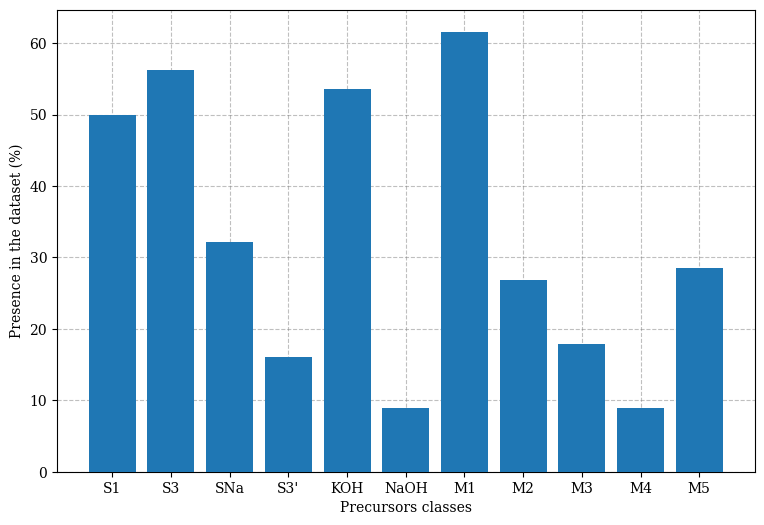

In [11]:
#Precursors count
precursors_names = ["S1", "S3", "SNa", "S3'", "KOH", "NaOH", "M1", "M2", "M3", "M4", "M5"]
precursors_count = Numpy.count_nonzero(precursors, axis = 0) / len(precursors)
    
Pyplot.clf()
fig, ax = Pyplot.subplots(1,1, figsize=(9,6))
ax.grid(color='gray', linestyle='--', alpha=0.5, zorder=0)
ax.bar( precursors_names, precursors_count* 100, zorder=3)
Pyplot.xlabel( "Precursors classes", fontsize=10 )
Pyplot.ylabel( "Presence in the dataset (%)", fontsize=10 )
Pyplot.savefig( "results/data_visualization/precursors_count.png", dpi = 300 )
Pyplot.show()

### Properties histograms

<Figure size 640x480 with 0 Axes>

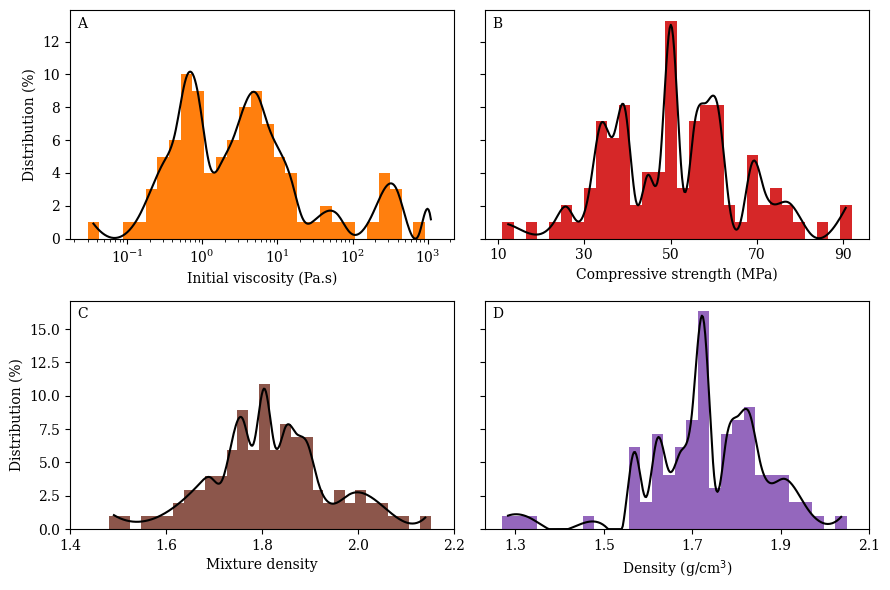

In [12]:
#Properties histograms
compressive_strength = c[c>0]
viscosity = v[v>0]
density = mv[mv>0]
mixture_density = d[d>0]
n_bins = HIST_N_BINS

Pyplot.clf()
fig, ((ax2,ax1),(ax4,ax3)) = Pyplot.subplots(2,2, figsize=(9,6), sharey='row')

ax1.hist(compressive_strength, color = "tab:red", bins = n_bins, weights = Numpy.ones(len(compressive_strength)) / len(compressive_strength) * 100)
count, bin_edges = Numpy.histogram(compressive_strength, bins = n_bins, weights = Numpy.ones(len(compressive_strength)) / len(compressive_strength) * 100)
hist_spline, x_bins, bin_edges = getSplineHist(compressive_strength, 30)
ax1.plot(x_bins, hist_spline, c = "k")
ax1.set_xlabel( "Compressive strength (MPa)", fontsize=10 )
ax1.set_xticks([10,30,50,70,90])
ax1.annotate("B", xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize', verticalalignment='top')

log_v = Numpy.log10(viscosity)
hist, bins = Numpy.histogram(log_v, bins = n_bins)
ax2.hist(viscosity, color = "tab:orange", bins = 10**bins, weights = Numpy.ones(len(viscosity)) / len(viscosity) * 100 )
hist_spline, x_bins, bin_edges = getSplineHist(log_v, n_bins)
ax2.plot(10**x_bins, hist_spline, c = "k")
ax2.set_xlabel( "Initial viscosity (Pa.s)", fontsize=10 )
ax2.set_xscale('log')
ax2.set_ylabel("Distribution (%)",fontsize=10)
ax2.annotate("A", xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize', verticalalignment='top')

ax3.hist(density, color = "tab:purple", bins = n_bins, weights = Numpy.ones(len(density)) / len(density) * 100)
hist_spline, x_bins, bin_edges = getSplineHist(density, n_bins)
ax3.plot(x_bins, hist_spline, c = "k")
ax3.set_xticks([1.3,1.5,1.7,1.9,2.1])
ax3.set_xlabel( "Density (g/cm$^{3}$)", fontsize=10 )
ax3.annotate("D", xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize', verticalalignment='top')

ax4.hist(mixture_density, color = "tab:brown", bins = n_bins, weights = Numpy.ones(len(mixture_density)) / len(mixture_density) * 100)
hist_spline, x_bins, bin_edges = getSplineHist(mixture_density, n_bins)
ax4.plot(x_bins, hist_spline, c = "k")
ax4.set_xticks([1.4,1.6,1.8,2.0,2.2])
ax4.set_xlabel( "Mixture density", fontsize=10 )
ax4.set_ylabel("Distribution (%)",fontsize=10)
ax4.annotate("C", xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize', verticalalignment='top')

Pyplot.tight_layout()
Pyplot.savefig( "results/data_visualization/properties_hist.png", dpi = 300 )
Pyplot.show()

### Properties histograms 2D

/tmp/ipykernel_21618/4136704536.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  Pyplot.tight_layout()


<Figure size 640x480 with 0 Axes>

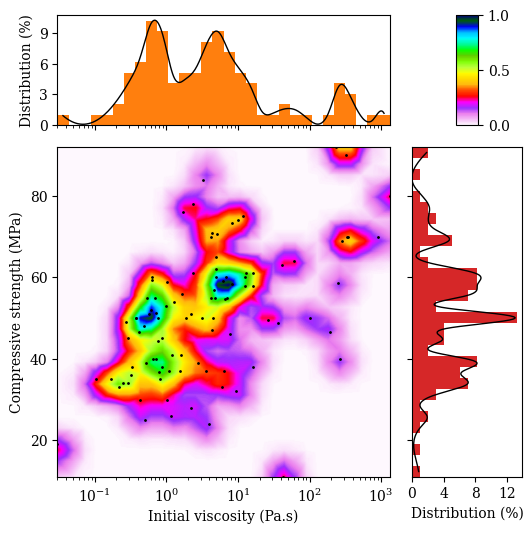

<Figure size 640x480 with 0 Axes>

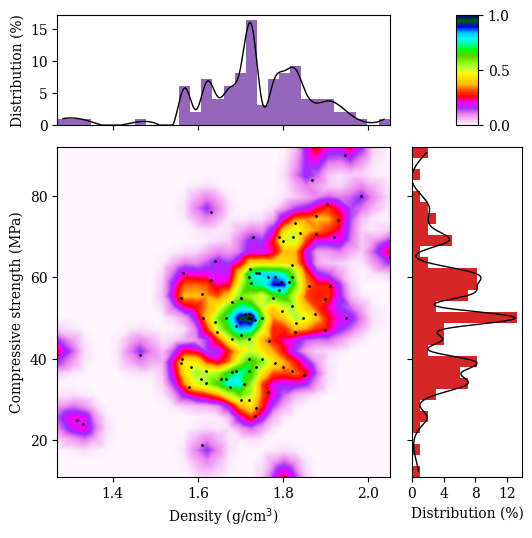

<Figure size 640x480 with 0 Axes>

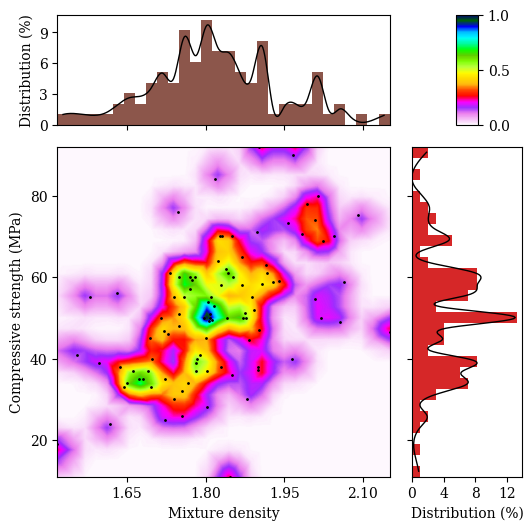

<Figure size 640x480 with 0 Axes>

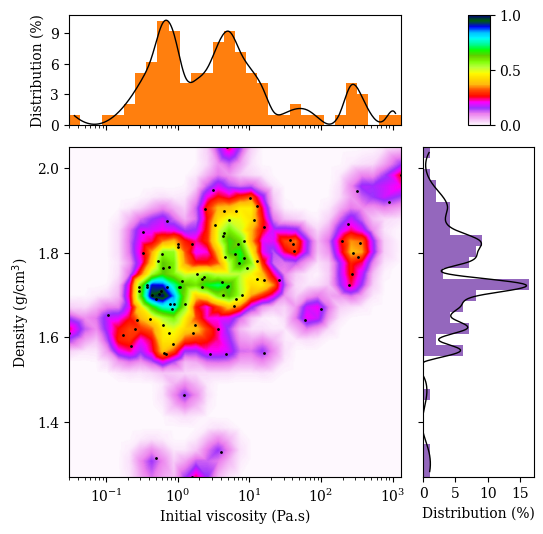

<Figure size 640x480 with 0 Axes>

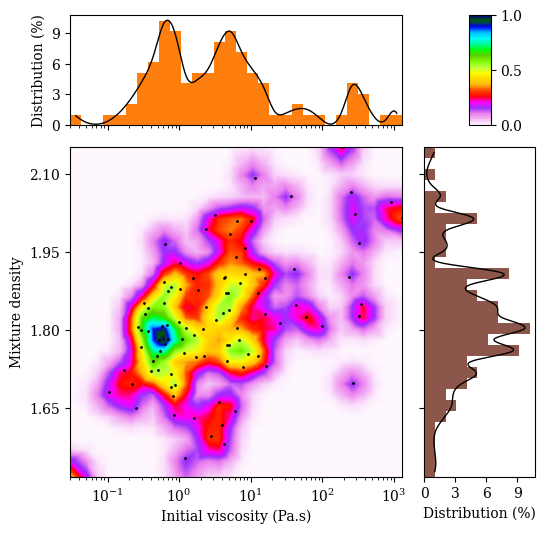

<Figure size 640x480 with 0 Axes>

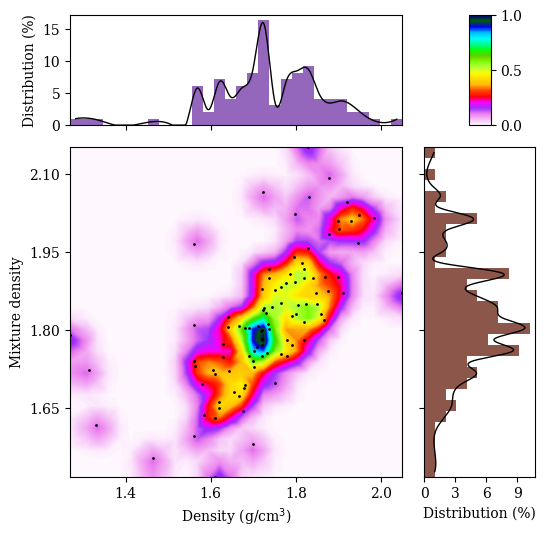

<Figure size 640x480 with 0 Axes>

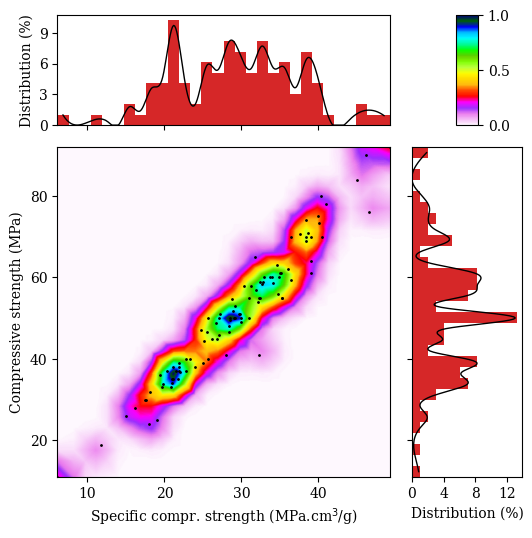

<Figure size 640x480 with 0 Axes>

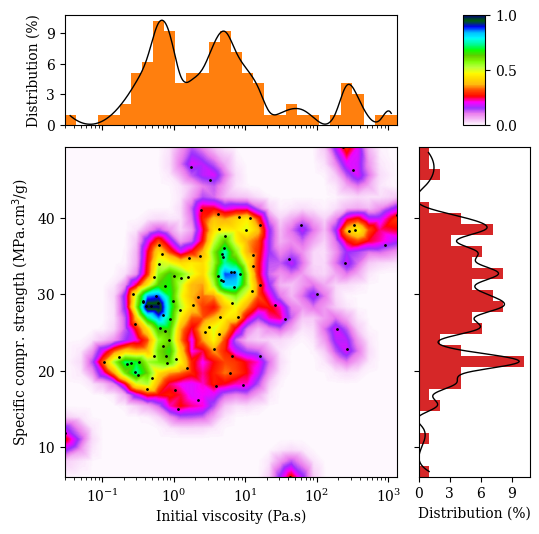

<Figure size 640x480 with 0 Axes>

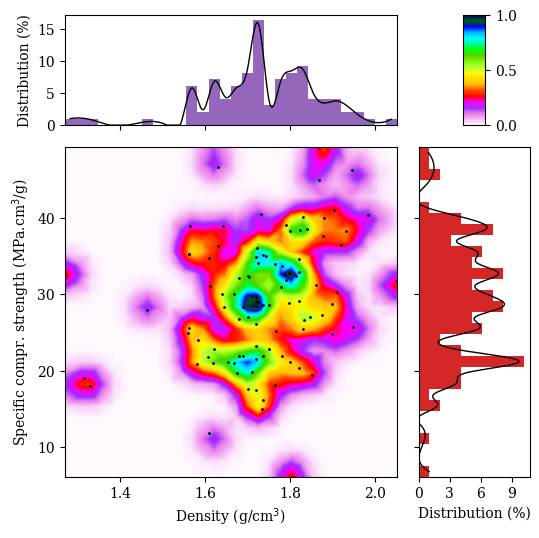

<Figure size 640x480 with 0 Axes>

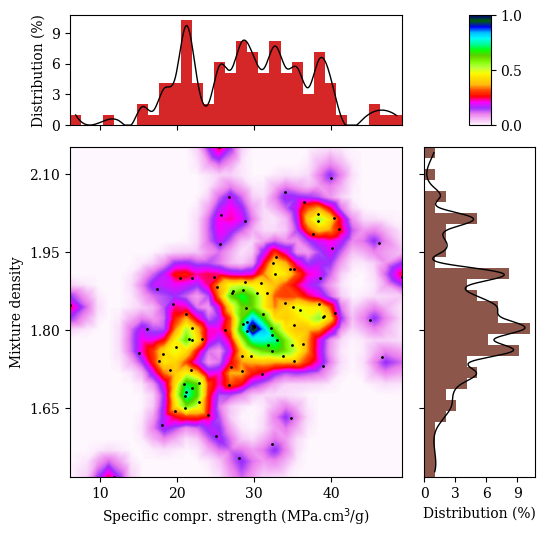

In [13]:
#Properties histograms 2D
compressive_strength = c[mv>0]
viscosity = v[mv>0]
density = mv[mv>0]
mixture_density = d[mv>0]
specific_compressive_strength = compressive_strength / density
folder = "results/data_visualization"
    
hist2D(viscosity,compressive_strength, "Initial viscosity (Pa.s)", "Compressive strength (MPa)", f"{folder}/compression_viscosite.png", x_color = "tab:orange", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500, x_scale = "log")

hist2D(density,compressive_strength, "Density (g/cm$^{3}$)", "Compressive strength (MPa)", f"{folder}/compression_masse_volumique.png", x_color = "tab:purple", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500)
hist2D(mixture_density,compressive_strength, "Mixture density", "Compressive strength (MPa)", f"{folder}/compression_densite.png", x_color = "tab:brown", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500)

hist2D(viscosity, density, "Initial viscosity (Pa.s)", "Density (g/cm$^{3}$)", f"{folder}/masse_volumique_viscosite.png", x_color = "tab:orange", y_color = "tab:purple", nxbins = n_bins, nybins = n_bins, nbins = 500, x_scale = "log")
hist2D(viscosity, mixture_density, "Initial viscosity (Pa.s)", "Mixture density", f"{folder}/densite_viscosite.png", x_color = "tab:orange", y_color = "tab:brown", nxbins = n_bins, nybins = n_bins, nbins = 500, x_scale = "log")

hist2D(density, mixture_density, "Density (g/cm$^{3}$)", "Mixture density", f"{folder}/densite_masse_volumique.png", x_color = "tab:purple", y_color = "tab:brown", nxbins = n_bins, nybins = n_bins, nbins = 500)

hist2D(specific_compressive_strength,compressive_strength, "Specific compr. strength (MPa.cm$^{3}$/g)", "Compressive strength (MPa)", f"{folder}/compression_specific_compression.png", x_color = "tab:red", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500)

hist2D(viscosity, specific_compressive_strength, "Initial viscosity (Pa.s)", "Specific compr. strength (MPa.cm$^{3}$/g)", f"{folder}/specific_compression_viscosite.png", x_color = "tab:orange", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500, x_scale = "log")
hist2D(density, specific_compressive_strength, "Density (g/cm$^{3}$)", "Specific compr. strength (MPa.cm$^{3}$/g)", f"{folder}/specific_compression_masse_volumique.png", x_color = "tab:purple", y_color = "tab:red", nxbins = n_bins, nybins = n_bins, nbins = 500)
hist2D(specific_compressive_strength, mixture_density, "Specific compr. strength (MPa.cm$^{3}$/g)", "Mixture density", f"{folder}/densite_specific_compression.png", x_color = "tab:red", y_color = "tab:brown", nxbins = n_bins, nybins = n_bins, nbins = 500)

### Properties Heatmaps with precursor families

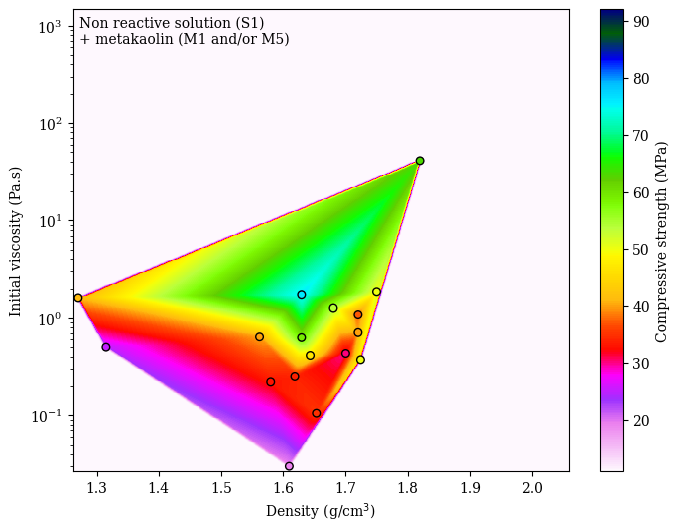

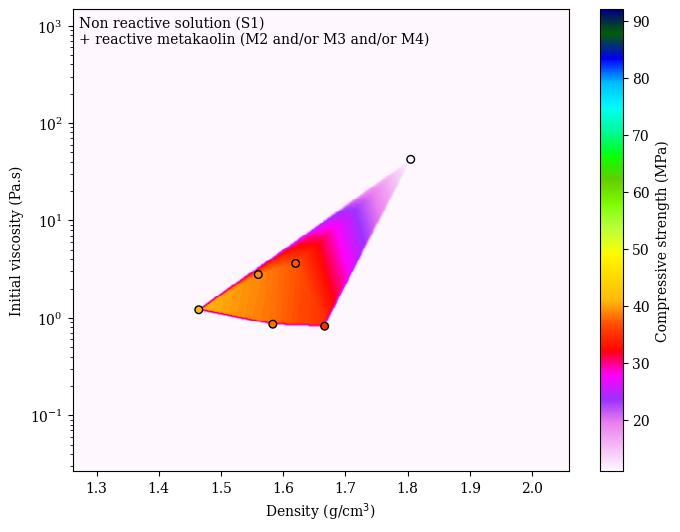

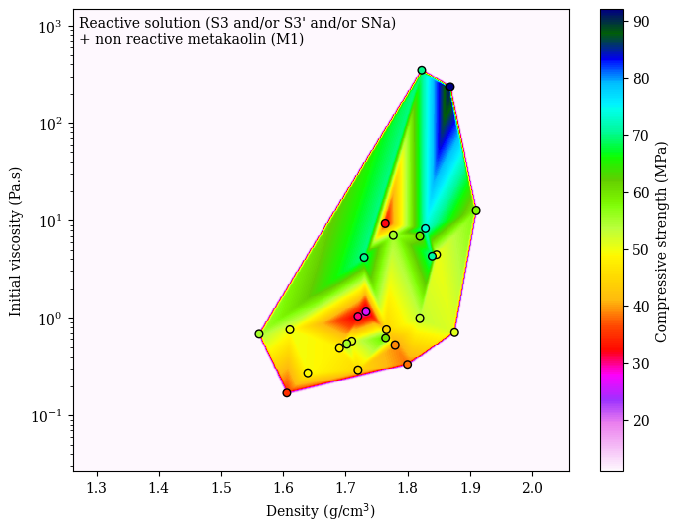

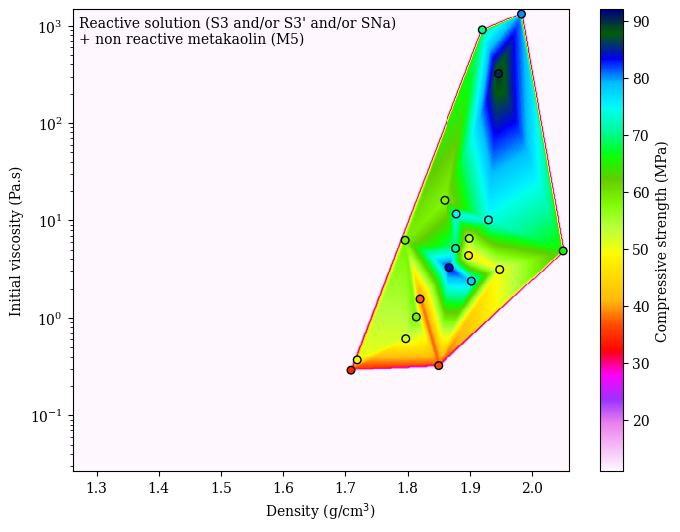

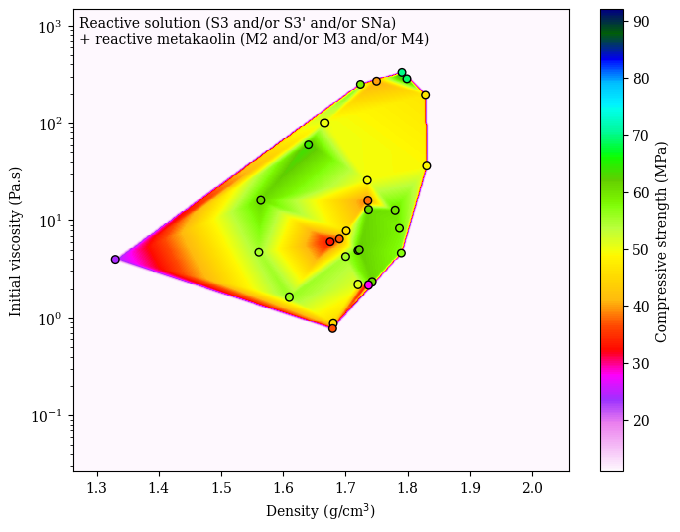

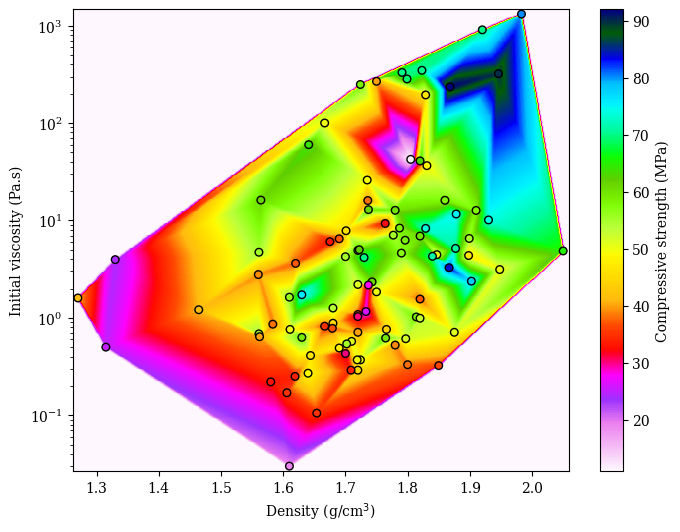

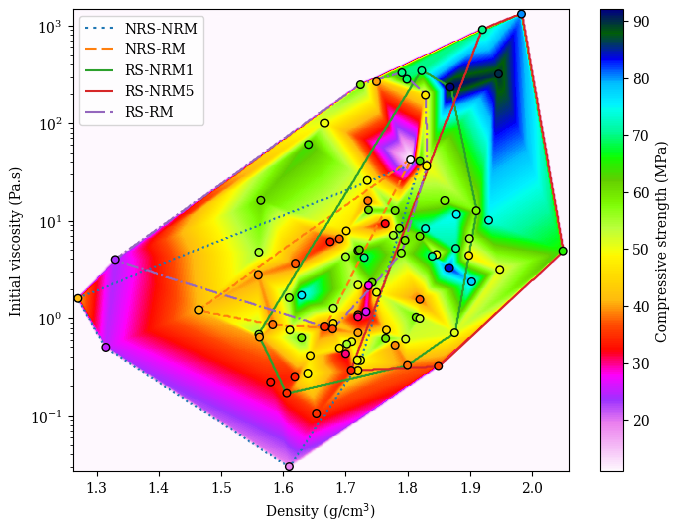

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.collections.QuadMesh at 0x7f70e3b7be20>)

In [14]:
def propertiesHeatmapsWithMixtureFamilies(properties, precursors, folder, properties_indexes = [1,0,2], labels = ['Density (g/cm$^{3}$)', "Initial viscosity (Pa.s)", 'Compressive strength (MPa)']):
    if not (isinstance(properties_indexes, list) and len(properties_indexes) == 3):
        raise TypeError( "properties_indexes must be a list length of 3" )
    
    if not (isinstance(labels, list) and len(labels) == 3):
        raise TypeError( "labels must be a list length of 3" )

    i, j, k = properties_indexes
    x, y, z = [properties[:,i], properties[:,j], properties[:,k]]
    precursors, properties = classifyDataByMixtureFamilies(precursors, properties)

    areas = [
        [properties["nrs_nrm"][:,i], properties["nrs_nrm"][:,j], properties["nrs_nrm"][:,k]],
        [properties["nrs_rm"][:,i], properties["nrs_rm"][:,j], properties["nrs_rm"][:,k]],
        [properties["rs_nrm1"][:,i], properties["rs_nrm1"][:,j], properties["rs_nrm1"][:,k]],
        [properties["rs_nrm5"][:,i], properties["rs_nrm5"][:,j], properties["rs_nrm5"][:,k]],
        [properties["rs_rm"][:,i], properties["rs_rm"][:,j], properties["rs_rm"][:,k]]]

    areas_labels = ["NRS-NRM", "NRS-RM", "RS-NRM1", "RS-NRM5", "RS-RM"]

    x_min = x.min()
    x_max = x.max()
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    heatmap(areas[0][0], areas[0][1], areas[0][2], labels[0], labels[1], labels[2], f"{folder}/heatmap_NRS_NRM.png", label = "Non reactive solution (S1)\n+ metakaolin (M1 and/or M5)", xmin = x_min, xmax = x_max, ymin = Numpy.log10(y_min), ymax = Numpy.log10(y_max), zmin = z_min, zmax = z_max, y_scale = 'log' )
    heatmap(areas[1][0], areas[1][1], areas[1][2], labels[0], labels[1], labels[2], f"{folder}/heatmap_NRS_RM.png", label = "Non reactive solution (S1)\n+ reactive metakaolin (M2 and/or M3 and/or M4)", xmin = x_min, xmax = x_max, ymin = Numpy.log10(y_min), ymax = Numpy.log10(y_max), zmin = z_min, zmax = z_max, y_scale = 'log' )
    heatmap(areas[2][0], areas[2][1], areas[2][2], labels[0], labels[1], labels[2], f"{folder}/heatmap_RS_NRM1.png", label = "Reactive solution (S3 and/or S3' and/or SNa)\n+ non reactive metakaolin (M1)", xmin = x_min, xmax = x_max, ymin = Numpy.log10(y_min), ymax = Numpy.log10(y_max), zmin = z_min, zmax = z_max, y_scale = 'log' )
    heatmap(areas[3][0], areas[3][1], areas[3][2], labels[0], labels[1], labels[2], f"{folder}/heatmap_RS_NRM5.png", label = "Reactive solution (S3 and/or S3' and/or SNa)\n+ non reactive metakaolin (M5)", xmin = x_min, xmax = x_max, ymin = Numpy.log10(y_min), ymax = Numpy.log10(y_max), zmin = z_min, zmax = z_max, y_scale = 'log' )
    heatmap(areas[4][0], areas[4][1], areas[4][2], labels[0], labels[1], labels[2], f"{folder}/heatmap_RS_RM.png", label = "Reactive solution (S3 and/or S3' and/or SNa)\n+ reactive metakaolin (M2 and/or M3 and/or M4)", xmin = x_min, xmax = x_max, ymin = Numpy.log10(y_min), ymax = Numpy.log10(y_max), zmin = z_min, zmax = z_max, y_scale = 'log' )
    
    heatmap(x, y, z, labels[0], labels[1], labels[2], f"{folder}/heatmap.png", y_scale = 'log')
    return heatmap(x, y, z, labels[0], labels[1], labels[2], f"{folder}/heatmap_with_families.png", y_scale = 'log', areas = areas, areas_labels = areas_labels)

propertiesHeatmapsWithMixtureFamilies(properties[mv>0], precursors[mv>0], "results/data_visualization")

## Pre-process training data for neural networks

In [15]:
v, v_mean, v_std = normalizeData(file.getColumn( "viscosité (Pa.s)" ), should_standardize = False)
mv, mv_mean, mv_std = normalizeData(file.getColumn( "masse volumique" ))
c, c_mean, c_std = normalizeData(file.getColumn( "compression 7j (MPa)" ))
d, d_mean, d_std = normalizeData(file.getColumn( "Densité (g/cm3)" ))

v, v_min, v_max = splitViscosity(v, LOW_VISCOSITY_MAX, MEDIUM_VISCOSITY_MAX, v_mean)

STD_VISCOSITE_MIN = -1
STD_MASSE_VOLUMIQUE_MIN = ( -1 - mv_mean ) / mv_std
STD_COMPRESSION_MIN = ( -1 - c_mean ) / c_std
STD_DENSITE_MIN = ( -1 - d_mean ) / d_std

std_properties = Numpy.concatenate([v_max - v_min, [mv_std, c_std, d_std]])
mean_properties = Numpy.concatenate([v_min, [mv_mean, c_mean, d_mean]])

properties = Numpy.swapaxes([v[:,0], v[:,1], v[:,2], mv, c, d], 0, 1)
siM_sol, siAl, solidLiquid = Numpy.swapaxes(map_( precursors, lambda x : getMoleRatios( x ) ), 0, 1)

random_indexes = Numpy.arange(len(properties))
Numpy.random.shuffle( random_indexes )
X = Numpy.array(properties)[random_indexes]
y1 = Numpy.array(precursors)[random_indexes]
y3 = Numpy.array(siM_sol)[random_indexes]
y4 = Numpy.array(siAl)[random_indexes]
y5 = Numpy.array(solidLiquid)[random_indexes]

2025-08-29 10:37:13.943224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 10:37:13.944384: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Neural networks models declaration

In [16]:
def sampling(args):
    z_mean, z_log_var, latent_dim = args
    epsilon = Tensorflow.random.normal( shape = ( Backend.shape(z_mean)[0], latent_dim ), mean = 0, stddev = 1. )
    return z_mean + Backend.exp(z_log_var) * epsilon
    
def createSimulator(latent_dim = 32):
    precursors = Input( shape = (NB_PRECURSORS) )

    ratios, ratio_m1, ratio_m2, ratio_m3, ratio_m4, ratio_m5 = Tensorflow.split( precursors, [6, 1, 1, 1, 1, 1], -1 )
    std_properties_min = Tensorflow.convert_to_tensor([STD_VISCOSITE_MIN, STD_VISCOSITE_MIN, STD_VISCOSITE_MIN, STD_MASSE_VOLUMIQUE_MIN, STD_COMPRESSION_MIN, STD_DENSITE_MIN], dtype = Tensorflow.float32)

    #Molar ratios from precursors
    mole_ratios = Layers.Lambda( lambda x: getMoleRatios( x ) )( precursors )
    siM_sol = Layers.Lambda( lambda x: Tensorflow.gather( x, 0 ) )( mole_ratios )
    siAl = Layers.Lambda( lambda x: Tensorflow.gather( x, 1 ) )( mole_ratios )
    solidLiquid = Layers.Lambda( lambda x: Tensorflow.gather( x, 2 ) )( mole_ratios )
    
    x = Layers.Concatenate()([precursors, siM_sol, siAl, solidLiquid])

    #Encoder
    x = Layers.Dense( 128, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 128, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )

    #Latent space
    z_mean = Layers.Dense( latent_dim )( x )
    z_log_var = Layers.Dense( latent_dim )( x )
    z = Layers.Lambda( sampling )( [z_mean, z_log_var, latent_dim] )
    
    x = Layers.Dense( 64, activation = Layers.PReLU() )( z )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 128, activation = "relu" )( x )
    x = Layers.Dense( 128, activation = "relu" )( x )

    viscosity = Layers.Dense( 3 )( x )
    density = Layers.Dense( 1 )( x )
    compression = Layers.Dense( 1 )( x )
    mixture_density = Layers.Dense( 1 )( x )
    properties = Layers.Concatenate()( [viscosity, density, compression, mixture_density] )

    #Control the geopolymer molar ratios limits
    properties = Tensorflow.where( Tensorflow.logical_or( siM_sol >= 1.1, siM_sol <= 0.2 ), std_properties_min, properties )
    properties = Tensorflow.where( Tensorflow.logical_or( siAl >= 3, siAl <= 1.3 ), std_properties_min, properties )
    
    properties_m1_m5 = Tensorflow.where( Tensorflow.logical_or( solidLiquid >= 2, solidLiquid <= 0.44 ), std_properties_min, properties )
    properties_m2_m4 = Tensorflow.where( Tensorflow.logical_or( solidLiquid >= 0.78, solidLiquid <= 0.44 ), std_properties_min, properties )
    properties_m3 = Tensorflow.where( Tensorflow.logical_or( solidLiquid >= 0.85, solidLiquid <= 0.44 ), std_properties_min, properties )
    
    properties = Tensorflow.where( Tensorflow.logical_or( ratio_m1 > 0.1, ratio_m5 > 0.2 ), properties_m1_m5, Tensorflow.where( ratio_m3 > 0.2, properties_m3, properties_m2_m4 ) )
    viscosity, density, compression, mixture_density = Tensorflow.split( properties, [3, 1, 1, 1], -1 )

    #Output
    viscosity = Layers.Lambda( lambda x: x, name = "viscosity" )( viscosity )
    density = Layers.Lambda( lambda x: x, name = "density" )( density )
    compression = Layers.Lambda( lambda x: x, name = "compression" )( compression )
    mixture_density = Layers.Lambda( lambda x: x, name = "mixture_density" )( mixture_density )
    
    simulator = Model( precursors, [viscosity, density, compression, mixture_density] )
    simulator.compile( optimizer = RMSprop( learning_rate = 0.0005 ), loss = { "viscosity": "mae", "density": "mae", "compression": "mae", "mixture_density": "mae" } )
    
    return simulator

def createFormulator(latent_dim = 32):
    properties = Input( shape = (NB_PROPERTIES) )

    x = properties

    x = Layers.Dense( 128, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 128, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )
    
    z_mean = Layers.Dense( latent_dim )( x )
    z_log_var = Layers.Dense( latent_dim )( x )
    z = Layers.Lambda( sampling )( [z_mean, z_log_var, latent_dim] )
    
    x = Layers.Dense( 64, activation = Layers.PReLU() )( z )
    x = Layers.Dense( 64, activation = Layers.PReLU() )( x )
    x = Layers.Dense( 128, activation = "relu" )( x )
    x = Layers.Dense( 128, activation = "relu" )( x )
    
    precursors = Layers.Dense( NB_PRECURSORS, activation = "sigmoid", name = "precursors" )( x )
    sums = Layers.Lambda( lambda x : Tensorflow.math.reduce_sum( x, axis = -1 ), name = "sums" )( precursors )
    mole_ratios = Layers.Lambda( lambda x: getMoleRatios( x ) )( precursors )
    siM_sol = Layers.Lambda( lambda x: Tensorflow.gather( x, 0 ), name = "siM_sol" )( mole_ratios )
    siAl = Layers.Lambda( lambda x: Tensorflow.gather( x, 1 ), name = "siAl" )( mole_ratios )
    solidLiquid = Layers.Lambda( lambda x: Tensorflow.gather( x, 2 ), name = "solidLiquid" )( mole_ratios )
    
    formulator = Model( properties, [precursors, sums, siM_sol, siAl, solidLiquid] )
    formulator.compile( optimizer = RMSprop( learning_rate = 0.0005 ), loss = "mae" )
    
    return formulator

def createTrainer( simulator, formulator ):
    properties = Input( shape = (NB_PROPERTIES) )
    
    simulator.trainable = False
    
    formulated_precursors, sums, siM_sol, siAl, solidLiquid = formulator( properties )
    formulated_precursors = Layers.Lambda( lambda x : x, name = "precursors" )( formulated_precursors )
    sums = Layers.Lambda( lambda x : x, name = "sums" )( sums )
    siM_sol = Layers.Lambda( lambda x: x, name = "siM_sol" )( siM_sol )
    siAl = Layers.Lambda( lambda x: x, name = "siAl" )( siAl )
    solidLiquid = Layers.Lambda( lambda x: x, name = "solidLiquid" )( solidLiquid )
    
    viscosity, density, compression, mixture_density  = simulator( formulated_precursors )
    simulated_properties = Layers.Concatenate()( [viscosity, density, compression, mixture_density] )
    simulated_properties = Layers.Lambda( lambda x: x, name = "properties" )(  simulated_properties )
    
    trainer = Model( properties, [formulated_precursors, sums, siM_sol, siAl, solidLiquid, simulated_properties] )
    trainer.compile( optimizer = RMSprop( learning_rate = 0.0005 ), loss = "mae", loss_weights = { "precursors" : 5, "sums" : 2, "siM_sol": 1, "siAl": 1, "solidLiquid": 1, "properties": 1 } )
    
    return trainer


## Load or create, train and save GEOMIND models

In [18]:
if SHOULD_LOAD_MODELS:
    formulator = load_model("saved_models/Formulator")
    simulator = load_model("saved_models/Simulator")
else:
    formulator = createFormulator()
    simulator = createSimulator()

    earlyStopping = EarlyStopping(monitor="loss", start_from_epoch = NB_EPOCHS_SIMULATOR, patience = 5, mode = "min", restore_best_weights = True)
    simulator.fit( y1, Tensorflow.split(X, [3,1,1,1], -1), epochs = NB_EPOCHS_SIMULATOR * 2, batch_size = BATCH_SIZE, verbose = 1, callbacks=[earlyStopping] )
    
    trainer = createTrainer( simulator, formulator )
    
    earlyStopping = EarlyStopping(monitor="loss", start_from_epoch = NB_EPOCHS_FORMULATOR, patience = 5, mode = "min", restore_best_weights = True)
    trainer.fit( X, [y1, Numpy.ones(len(y1)), y3, y4, y5, X], epochs = NB_EPOCHS_FORMULATOR * 2, batch_size = BATCH_SIZE, verbose = 1, callbacks=[earlyStopping] )
    
    simulator.save("saved_models/Simulator")
    formulator.save("saved_models/Formulator")

TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'start_from_epoch'

## Enter your material target properties

In [19]:
target_viscosity = float( input( "Initial viscosity (Pa.s): " ) )
target_mixture_density = float( input( "Mixture density: " ) )
target_compressive_strength = float( input( "Compressive strength (MPa): " ) )
target_density = float( input( "Density (g/cm3): " ) )

Initial viscosity (Pa.s):  10
Mixture density:  1
Compressive strength (MPa):  90
Density (g/cm3):  1.2


## Normalize target properties

In [20]:
target_v, v_min, v_max = splitViscosity([target_viscosity], LOW_VISCOSITY_MAX, MEDIUM_VISCOSITY_MAX, v_mean, v_min = v_min, v_max = v_max )
target_d = (target_mixture_density - d_mean) / d_std
target_c = (target_compressive_strength - c_mean) / c_std
target_mv = (target_density - mv_mean) / mv_std
target_properties = Numpy.array([[target_v[0,0], target_v[0,1], target_v[0,2], target_mv, target_c, target_d]])

## Predict precursors and properties

In [21]:
formulator_output = formulator.predict( target_properties )
target_precursors = formulator_output[0]
simulator_output = Numpy.concatenate( simulator.predict( target_precursors ), axis = -1)
simulated_properties = simulator_output * std_properties + mean_properties
simulated_properties = Numpy.where( simulated_properties < 0, -1, simulated_properties )
simulated_properties[:,0] = joinViscosity(simulated_properties[:,0], simulated_properties[:,1], simulated_properties[:,2])
simulated_properties = Numpy.delete(simulated_properties, [1,2], axis = -1)

1/1 [==============================] - 0s 331ms/step


## Print results

In [22]:
Numpy.set_printoptions(suppress=True,precision=2)

print("--Propriétés cibles--")
print(f"Initial viscosity (Pa.s): {target_viscosity}")
print(f"Mixture density: {target_mixture_density}")
print(f"Compressive strength (MPa): {target_compressive_strength}")
print(f"Density (g/cm3): {target_density}")
print("")
print("--Précurseurs (%) prédits--")
print("S1 | S3 | SNa | S3' | KOH | NaOH | M1 | M2 | M3 | M4 | M5")
print(target_precursors[0])
print("")
print("--Propriétés prédites--")
print(f"Initial viscosity (Pa.s): {simulated_properties[0,0]}")
print(f"Mixture density: {simulated_properties[0,3]}")
print(f"Compressive strength (MPa): {simulated_properties[0,2]}")
print(f"Density (g/cm3): {simulated_properties[0,1]}")

--Propriétés cibles--
Initial viscosity (Pa.s): 10.0
Mixture density: 1.0
Compressive strength (MPa): 90.0
Density (g/cm3): 1.2

--Précurseurs (%) prédits--
S1 | S3 | SNa | S3' | KOH | NaOH | M1 | M2 | M3 | M4 | M5
[0.46 0.52 0.62 0.44 0.42 0.46 0.48 0.5  0.42 0.46 0.5 ]

--Propriétés prédites--
Initial viscosity (Pa.s): -1.0
Mixture density: 1.2085439351342304
Compressive strength (MPa): 45.91942597718182
Density (g/cm3): 1.5620275642770414


## Run all in one test

In [23]:
target_viscosity = float( input( "Initial viscosity (Pa.s): " ) )
target_mixture_density = float( input( "Mixture density: " ) )
target_compressive_strength = float( input( "Compressive strength (MPa): " ) )
target_density = float( input( "Density (g/cm3): " ) )

target_v, v_min, v_max = splitViscosity([target_viscosity], LOW_VISCOSITY_MAX, MEDIUM_VISCOSITY_MAX, v_mean, v_min = v_min, v_max = v_max )
target_d = (target_mixture_density - d_mean) / d_std
target_c = (target_compressive_strength - c_mean) / c_std
target_mv = (target_density - mv_mean) / mv_std
target_properties = Numpy.array([[target_v[0,0], target_v[0,1], target_v[0,2], target_mv, target_c, target_d]])

formulator_output = formulator.predict( target_properties )
target_precursors = formulator_output[0]
simulator_output = Numpy.concatenate( simulator.predict( target_precursors ), axis = -1)
simulated_properties = simulator_output * std_properties + mean_properties
simulated_properties = Numpy.where( simulated_properties < 0, -1, simulated_properties )
simulated_properties[:,0] = joinViscosity(simulated_properties[:,0], simulated_properties[:,1], simulated_properties[:,2])
simulated_properties = Numpy.delete(simulated_properties, [1,2], axis = -1)

Numpy.set_printoptions(suppress=True,precision=2)

print("--Propriétés cibles--")
print(f"Initial viscosity (Pa.s): {target_viscosity}")
print(f"Mixture density: {target_mixture_density}")
print(f"Compressive strength (MPa): {target_compressive_strength}")
print(f"Density (g/cm3): {target_density}")
print("")
print("--Précurseurs (%) prédits--")
print("S1 | S3 | SNa | S3' | KOH | NaOH | M1 | M2 | M3 | M4 | M5")
print(target_precursors[0])
print("")
print("--Propriétés prédites--")
print(f"Initial viscosity (Pa.s): {simulated_properties[0,0]}")
print(f"Mixture density: {simulated_properties[0,3]}")
print(f"Compressive strength (MPa): {simulated_properties[0,2]}")
print(f"Density (g/cm3): {simulated_properties[0,1]}")

Initial viscosity (Pa.s):  15
Mixture density:  1.2
Compressive strength (MPa):  80
Density (g/cm3):  1.05


1/1 [==============================] - 0s 94ms/step
--Propriétés cibles--
Initial viscosity (Pa.s): 15.0
Mixture density: 1.2
Compressive strength (MPa): 80.0
Density (g/cm3): 1.05

--Précurseurs (%) prédits--
S1 | S3 | SNa | S3' | KOH | NaOH | M1 | M2 | M3 | M4 | M5
[0.41 0.49 0.53 0.46 0.53 0.48 0.51 0.48 0.49 0.43 0.51]

--Propriétés prédites--
Initial viscosity (Pa.s): 2.426464471947402
Mixture density: 1.355746572578599
Compressive strength (MPa): 44.4694526715871
Density (g/cm3): 1.463700440389928
